In [1]:
import os 
from pathlib import Path
from dotenv import load_dotenv
import pickle
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from setup_plot import setup_plot
import matplotlib.ticker as mtick

/home/aayush/rl_mind_dataset/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

True

In [3]:
import io
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

In [4]:
base_path = Path.home()/Path(os.environ.get("TEST_PATH"))

In [5]:
SEEDS = [5, 42, 97, 33, 99]
window = 100

In [6]:
def parse_data(data_dict: dict, alg_nam:str, seed: int)->pd.DataFrame:
    # convert from torch to float
    for k, v in data_dict.items():
        if isinstance(v, torch.Tensor):
            data_dict[k] = v.item()
        elif isinstance(v, list):
            if isinstance(v[0], torch.Tensor):
                data_dict[k] = [x.item() for x in v]
    data_df = pd.DataFrame(data_dict)
    data_df["alg_name"] = alg_nam
    data_df["seed"] = seed
    data_df = data_df.reset_index().rename(columns={"index": "episode"})
    return data_df

In [7]:
res_df_list = []
for seed in tqdm(SEEDS):
    slateq_dict = pickle.load(open(base_path / Path(f"slateq_generalist_{seed}")/ "logs_dict.pickle", "rb"))
    res_df = parse_data(slateq_dict, "SlateQ_Gen", seed)
    res_df_list.append(res_df)
# concat all results
final_df = pd.concat(res_df_list)

  0%|          | 0/5 [00:00<?, ?it/s]/home/aayush/rl_mind_dataset/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


In [8]:
res_df_list = []
for seed in tqdm(SEEDS):
    slateq_dict = pickle.load(open(base_path / Path(f"slateq_specialist_{seed}")/ "logs_dict.pickle", "rb"))
    res_df = parse_data(slateq_dict, "SlateQ_Spec", seed)
    res_df_list.append(res_df)
# concat all results
slateq_spec_df = pd.concat(res_df_list)
final_df = pd.concat([final_df, slateq_spec_df])

100%|██████████| 5/5 [00:00<00:00, 12.72it/s]


In [9]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
res_df_list = []
for seed in tqdm(SEEDS):
    slateq_dict = pickle.load(open(base_path / Path(f"wp_slate_specialist_{seed}")/ "logs_dict.pickle", "rb"))
    res_df = parse_data(slateq_dict, "SlateWP_Spec", seed)
    res_df_list.append(res_df)
# concat all results
slatewp_spec_df = pd.concat(res_df_list)
final_df = pd.concat([final_df, slatewp_spec_df])

100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


In [10]:
res_df_list = []
device = torch.device('cpu')
os.environ['CUDA_LAUNCH_BLOCKING'] = '0'
for seed in tqdm(SEEDS):
    slateq_dict = CPU_Unpickler(open(base_path / Path(f"wp_slate_generalist_{seed}")/ "logs_dict.pickle", "rb")).load()
    res_df = parse_data(slateq_dict, "SlateWP_Gen", seed)
    res_df_list.append(res_df)
# concat all results
slatewp_gen_df = pd.concat(res_df_list)
final_df = pd.concat([final_df, slatewp_gen_df])

100%|██████████| 5/5 [00:00<00:00, 18.22it/s]


In [11]:
res_df_list = []
for seed in tqdm(SEEDS):
    slateq_dict = pickle.load(open(base_path / Path(f"greedy_specialist_{seed}")/ "logs_dict.pickle", "rb"))
    res_df = parse_data(slateq_dict, "Greedy_Spec", seed)
    res_df_list.append(res_df)
# concat all results
greedy_spec_df = pd.concat(res_df_list)
final_df = pd.concat([final_df, greedy_spec_df])

100%|██████████| 5/5 [00:00<00:00, 18.63it/s]


In [12]:
res_df_list = []
for seed in tqdm(SEEDS):
    slateq_dict = pickle.load(open(base_path / Path(f"greedy_generalist_{seed}")/ "logs_dict.pickle", "rb"))
    res_df = parse_data(slateq_dict, "Greedy_Gen", seed)
    res_df_list.append(res_df)
# concat all results
greedy_gen_df = pd.concat(res_df_list)
final_df = pd.concat([final_df, greedy_gen_df])

100%|██████████| 5/5 [00:00<00:00, 12.68it/s]


In [13]:
final_df

,episode,hit_documents,ep_cum_satisfaction,ep_avg_satisfaction,diverse_score,user_satisfaction,relevance,alg_name,seed
0,0,0.000000,0.923530,0.461765,6,0.815647,0.748012,SlateQ_Gen,5
1,1,0.000000,0.782511,0.260837,7,0.970378,0.948471,SlateQ_Gen,5
2,2,0.000000,1.326244,0.331561,8,0.578357,0.579343,SlateQ_Gen,5
3,3,0.333333,0.887048,0.295683,6,0.992782,1.000000,SlateQ_Gen,5
4,4,0.000000,0.499515,0.249757,7,0.905194,0.901347,SlateQ_Gen,5
...,...,...,...,...,...,...,...,...,...
295,295,0.000000,0.861115,0.430557,5,0.936692,0.892076,Greedy_Gen,99
296,296,0.250000,1.279867,0.319967,5,0.897204,0.794945,Greedy_Gen,99
297,297,0.000000,0.568995,0.284497,4,0.942104,0.928786,Greedy_Gen,99
298,298,0.000000,1.803231,0.257604,3,0.954186,0.896401,Greedy_Gen,99


In [14]:
final_df

,episode,hit_documents,ep_cum_satisfaction,ep_avg_satisfaction,diverse_score,user_satisfaction,relevance,alg_name,seed
0,0,0.000000,0.923530,0.461765,6,0.815647,0.748012,SlateQ_Gen,5
1,1,0.000000,0.782511,0.260837,7,0.970378,0.948471,SlateQ_Gen,5
2,2,0.000000,1.326244,0.331561,8,0.578357,0.579343,SlateQ_Gen,5
3,3,0.333333,0.887048,0.295683,6,0.992782,1.000000,SlateQ_Gen,5
4,4,0.000000,0.499515,0.249757,7,0.905194,0.901347,SlateQ_Gen,5
...,...,...,...,...,...,...,...,...,...
295,295,0.000000,0.861115,0.430557,5,0.936692,0.892076,Greedy_Gen,99
296,296,0.250000,1.279867,0.319967,5,0.897204,0.794945,Greedy_Gen,99
297,297,0.000000,0.568995,0.284497,4,0.942104,0.928786,Greedy_Gen,99
298,298,0.000000,1.803231,0.257604,3,0.954186,0.896401,Greedy_Gen,99


In [15]:
final_df = final_df.reset_index(drop=True)

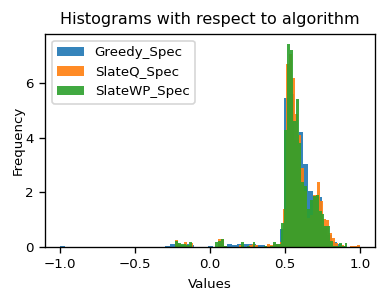

In [17]:


setup_plot(font_size=8, w_pts=256, fig_ratio=0.65)

# Set the plot style to "ticks"
# sns.set_style("whitegrid", {"grid.linestyle": "--", "axes.edgecolor": "black"})

grouped = final_df.groupby('alg_name')
# ax = sns.histplot(x="user_satisfaction", hue="alg_name", bins=30, data=final_df, kde=False)
# legend_entries = []

# for alg_name in final_df['alg_name'].unique():
#     legend_entries.append(plt.Line2D([0], [0], color=ax.get_legend_handles_labels()[1][list(final_df['alg_name'].unique()).index(alg_name)], lw=2, label=alg_name))

# Plotting histograms and normal distribution fits for each category
for category, group in grouped:
    if 'Spec' in category:
        values = group['ep_avg_satisfaction']
        plt.hist(values, bins=60, density=True, alpha=0.9, label=category)
    
    # mu, std = norm.fit(values)
    # xmin, xmax = plt.xlim()
    # x = np.linspace(xmin, xmax, 100)
    # p = norm.pdf(x, mu, std)
    # plt.plot(x, p, linewidth=2, label=f'{category} fit')

# Adding legend
plt.legend()
# legend=plt.legend(handles=legend_entries,title='', fancybox=False)
# fmt = mtick.ScalarFormatter(useMathText=True)
# fmt.set_powerlimits((-3,3))
# ax.xaxis.set_major_formatter(fmt)

# Adding labels and title
plt.title("Histograms with respect to algorithm")
plt.xlabel("Values")
plt.ylabel("Frequency", labelpad=0)

plt.show()

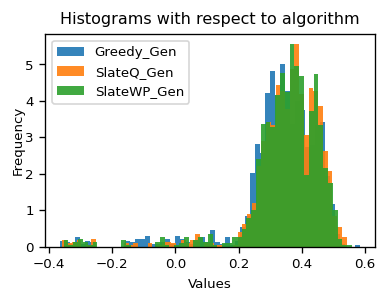

In [18]:

setup_plot(font_size=8, w_pts=256, fig_ratio=0.65)

# Set the plot style to "ticks"
# sns.set_style("whitegrid", {"grid.linestyle": "--", "axes.edgecolor": "black"})

grouped = final_df.groupby('alg_name')
# ax = sns.histplot(x="user_satisfaction", hue="alg_name", bins=30, data=final_df, kde=False)
# legend_entries = []

# for alg_name in final_df['alg_name'].unique():
#     legend_entries.append(plt.Line2D([0], [0], color=ax.get_legend_handles_labels()[1][list(final_df['alg_name'].unique()).index(alg_name)], lw=2, label=alg_name))

# Plotting histograms and normal distribution fits for each category
for category, group in grouped:
    if 'Gen' in category:
        values = group['ep_avg_satisfaction']
        plt.hist(values, bins=60, density=True, alpha=0.9, label=category)
    
    # mu, std = norm.fit(values)
    # xmin, xmax = plt.xlim()
    # x = np.linspace(xmin, xmax, 100)
    # p = norm.pdf(x, mu, std)
    # plt.plot(x, p, linewidth=2, label=f'{category} fit')

# Adding legend
plt.legend()
# legend=plt.legend(handles=legend_entries,title='', fancybox=False)
# fmt = mtick.ScalarFormatter(useMathText=True)
# fmt.set_powerlimits((-3,3))
# ax.xaxis.set_major_formatter(fmt)

# Adding labels and title
plt.title("Histograms with respect to algorithm")
plt.xlabel("Values")
plt.ylabel("Frequency", labelpad=0)

plt.show()